## Streaming Sourmash

This notebook demonstrates how to use boink to perform a streaming analysis of sourmash minhash signatures. Boink includes the sourmash C++ header and exposes it with cpppy, and wraps it so it can be used with boink's sequence processors. This enables a simple way to perform fast streaming signature analysis in Python.

In [1]:
# First, import the necessary libraries

In [1]:
from boink import libboink
from boink.signatures import SourmashSignature

from sourmash import load_one_signature, MinHash
import screed

The boink `SourmashSignature.Signature` is derived from `KmerMinHash`, and so follows the same interface. This signature will contain 10000 hashes at a $K$ of 31.

In [2]:
all_signature = SourmashSignature.Signature.build(10000, 31, False, 42, 0)

`SourmashSignature` contains its own sequence processor. This processor is iterable; it will process the given sequences in chunks given by `fine_interval`. The default fine interval is 10000. Alternatively, we can call `process` to consume the entire sample.

In [3]:
processor = SourmashSignature.Processor.build(all_signature)

Let's get some data. We'll start with something small, an ecoli sequencing run.

In [5]:
!curl -L ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR434/ERR434643/ERR434643_1.fastq.gz | gunzip -c > ERR434643_1.fastq

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  119M  100  119M    0     0  7030k      0  0:00:17  0:00:17 --:--:-- 8832k


In [6]:
!curl -L ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR434/ERR434643/ERR434643_2.fastq.gz | gunzip -c > ERR434643_2.fastq

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  122M  100  122M    0     0  6846k      0  0:00:18  0:00:18 --:--:-- 9119k


The processor can handle single or paired mode natively. There's nothing special to be done with paired reads for sourmash, so the paired mode just consumes each sequence in the pair one after the other. This is a full sequencing run of ~3.5 million sequences; it should take about a minute to consume.

In [4]:
%time processor.process('ERR434643_1.fastq', 'ERR434643_2.fastq')

CPU times: user 33.4 s, sys: 353 ms, total: 33.7 s
Wall time: 33.6 s


3714646

If sourmash is installed, we can convert the signature to a `sourmash.MinHash` object to do further analysis.

In [5]:
all_mh = all_signature.to_sourmash()

In [6]:
all_mh

In [7]:
sig = MinHash(10000, 31)
for record in screed.open('ERR434643_1.fastq'):
    try:
        sig.add_sequence(record.sequence)
    except:
        pass
for record in screed.open('ERR434643_2.fastq'):
    try:
        sig.add_sequence(record.sequence)
    except:
        pass

In [8]:
sig.similarity(all_mh)

1.0

Now let's do it in chunked mode. We'll print info on the medium interval, which is contained in the state object.

In [10]:
chunked_signature = SourmashSignature.Signature.build(10000, 31, False, 42, 0)
processor = SourmashSignature.Processor.build(chunked_signature)

for n_reads, state in processor.chunked_process('ERR434643_1.fastq', 'ERR434643_2.fastq'):
    if state.medium:
        print('Processed', n_reads, 'sequences.')

Processed 100000 sequences.
Processed 200000 sequences.
Processed 300000 sequences.
Processed 400000 sequences.
Processed 500000 sequences.
Processed 600000 sequences.
Processed 700000 sequences.
Processed 800000 sequences.
Processed 900000 sequences.
Processed 1000000 sequences.
Processed 1100000 sequences.
Processed 1200000 sequences.
Processed 1300000 sequences.
Processed 1400000 sequences.
Processed 1500000 sequences.
Processed 1600000 sequences.
Processed 1700000 sequences.
Processed 1800000 sequences.
Processed 1900000 sequences.
Processed 2000000 sequences.
Processed 2100000 sequences.
Processed 2200000 sequences.
Processed 2300000 sequences.
Processed 2400000 sequences.
Processed 2500000 sequences.
Processed 2600000 sequences.
Processed 2700000 sequences.
Processed 2800000 sequences.
Processed 2900000 sequences.
Processed 3000000 sequences.
Processed 3100000 sequences.
Processed 3200000 sequences.
Processed 3300000 sequences.
Processed 3400000 sequences.
Processed 3500000 seque

The similarity should be exact...

In [11]:
chunked_mh = chunked_signature.to_sourmash()
chunked_mh.similarity(all_mh)

1.0

Now, using the chunked processor for reporting is a bit boring. A more interesting use-case is is to track within-sample distances -- streaming analysis.

In [15]:
distances = []
times = []

streaming_sig = SourmashSignature.Signature.build(10000, 31, False, 42, 0)
# We'll set the medium_interval to 250000
processor = SourmashSignature.Processor.build(streaming_sig, 10000, 250000)

# Calculate a distance at each interval. The iterator is over fine chunks.
prev_mh = None
for n_reads, state in processor.chunked_process('ERR434643_1.fastq', 'ERR434643_2.fastq'):
    curr_mh = streaming_sig.to_sourmash()
    if prev_mh is not None:
        distances.append(prev_mh.similarity(curr_mh))
        times.append(n_reads)
    prev_mh = curr_mh
    
    if state.medium:
        print(n_reads, 'reads.')
    

250000 reads.
500000 reads.
750000 reads.
1000000 reads.
1250000 reads.
1500000 reads.
1750000 reads.
2000000 reads.
2250000 reads.
2500000 reads.
2750000 reads.
3000000 reads.
3250000 reads.
3500000 reads.


In [13]:
from ficus import FigureManager
import seaborn as sns
import numpy as np

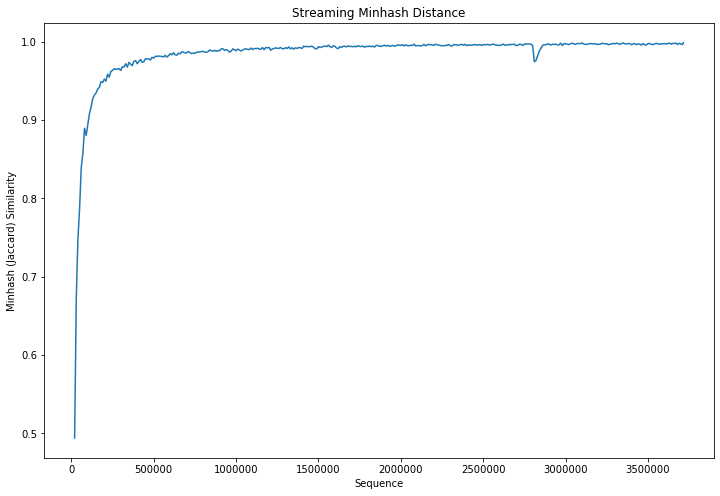

In [14]:
with FigureManager(show=True, figsize=(12,8)) as (fig, ax):
    sns.lineplot(times, distances, ax=ax)
    ax.set_title('Streaming Minhash Distance')
    ax.set_xlabel('Sequence')
    ax.set_ylabel('Minhash (Jaccard) Similarity')